# NN with word index input
The next method I tried was using word index to represent words then train an MLP and an RNN(LSTM, GRU).

In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, log_loss
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from nltk import FreqDist
import pickle as pkl
from os import path

%matplotlib inline

Using TensorFlow backend.


In [2]:
STOPWORDS = False
def clean(text):
    n = []
    for txt in text.strip().lower().split():
        txt = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', txt)
        txt = ' '.join(txt.split())
        txt = re.sub('[\W_]', '', txt)
        txt = ' '.join(txt.split())
        txt = re.sub(' [0-9]+ ', ' ', txt)
        txt = ' '.join(txt.split())
        txt = re.sub('^[0-9]+ ', ' ', txt)
        txt = ' '.join(txt.split())
        if re.match('^[0-9]+$', txt):
            continue
        if STOPWORDS and txt in stopwords.words('english'):
            continue
        if txt:
            n.append(txt)
    return ' '.join(n)

In [3]:
# vectorize docuemnnts
def encode_text(df, word_to_int, max_len=1000, clean=clean):
    documents = df['Text'].apply(clean)
    X = []
    for doc in documents:
        vector = []
        for word in doc.split():
            if word in word_to_int:
                vector.append(word_to_int[word])
            if len(vector) == max_len:
                break
        if len(vector) < max_len:
            vector = vector + [0] * (max_len - len(vector))
        X.append(vector)
    return np.array(X) / len(word_to_int)


# Create a word indexes dictionary
def build_word_dictionary(df, top_k=30000, clean=clean, filename=None):
    if filename is not None and path.exists(filename):
        with open(filename, 'rb') as f:
            return pkl.load(f)
    
    documents = df['Text'].apply(clean)
    genes = df['Gene'].apply(clean)
    variations = df['Gene'].apply(clean)
    
    words = [word for document in documents for word in document.split()]
    freq = FreqDist(words)
    word_to_int = dict(list(zip([w[0] for w in freq.most_common(top_k)], list(range(1, top_k)))))
    
    ix = len(word_to_int) + 1
    for gene in genes:
        if gene not in word_to_int:
            word_to_int[gene] = ix
            ix += 1
    
    for variation in variations:
        if variation not in word_to_int:
            word_to_int[variation] = ix
            ix += 1
    
    #word_to_int['UNK'] = ix
    
    if filename is not None:
        with open(filename, 'wb') as f:
            pkl.dump(word_to_int, f)
        
    return word_to_int

In [4]:
def add_dense_layer(model, size, activation, dropout, input_dim=None):
    model.add(Dense(size, input_dim=input_dim, activation=activation))
    if dropout:
        model.add(Dropout(dropout))
    return model

# construct an MLP model
def make_mlp(input_dim, layers=[512], activations=['relu'], dropout=False, optimizer='adam', lr=0.002):
    model = Sequential()
    model = add_dense_layer(model, layers[0], activations[0], dropout, input_dim=input_dim)
    for i in range(1, len(layers)):
        model = add_dense_layer(model, layers[i], activations[i], dropout)
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [24]:
def add_rnn_layer(model, size, activation, dropout, type='lstm', input_dim=(1, 1000)):
    if type == 'lstm':
        l = LSTM(size, input_shape=input_dim, activation=activation, dropout=dropout, recurrent_dropout=dropout)
    elif type == 'gru':
        l = GRU(size, input_shape=input_dim, activation=activation, dropout=dropout, recurrent_dropout=dropout)
    else:
        l = add_dense_layer(model, size, activation, dropout, input_dim)
    model.add(l)
    return model

# constructs a RNN model
def make_rnn(input_dim=(1, 1000), layers=[512], activations=['tanh'], layer_types=['lstm'], dropout=False, optimizer='adam', 
              lr=0.002):
    model = Sequential()
    model = add_rnn_layer(model, layers[0], activations[0], dropout, type=layer_types[0], input_dim=input_dim)
    for i in range(1, len(layers)):
        model = add_rnn_layer(model, layers[i], activations[i], dropout, type=layer_types[i])
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [6]:
def show_prediction_result(classifier, X, y):
    probas = classifier.predict_proba(X)
    indices = np.argmax(probas, axis=1)
    classes = np.array(list(range(9)))
    predictions = classes[indices]
    y_indices = np.argmax(y, axis=1)
    y_ = classes[y_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print(classification_report(y_, predictions))
    plot_confusion_matrix(y_, predictions)
    
def evaluate(classifier, X, y, X_test=None, y_test=None):
    classifier.fit(X, y)
    show_prediction_result(classifier, X, y)
    if X_test is not None:
        print('')
        print('Test set:')
        show_prediction_result(classifier, X_test, y_test)
    return classifier
        

In [7]:
training_variants = pd.read_csv('data/training_variants')
training_text = pd.read_csv('data/training_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
training_data = pd.merge(training_text, training_variants, on='ID')
training_data = training_data[training_data['Text'].apply(len) > 50]

test_variants = pd.read_csv('data/test_variants')
test_text = pd.read_csv('data/test_text', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_y = pd.read_csv('data/stage1_solution_filtered.csv')
test_data = pd.merge(test_text, test_variants, on='ID')
test_data = test_data.loc[test_data['ID'].isin(test_y['ID'].values)]

word_to_int = build_word_dictionary(training_data, filename='data/vectors/word_to_int.pkl')

X = encode_text(training_data, word_to_int)
y = training_data['Class'].values
y = to_categorical(y - 1, 9)

X_test = encode_text(test_data, word_to_int)
y_test = test_y.values[:, 1:]


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/100
3s - loss: 1.8297 - acc: 0.3275
Epoch 2/100
0s - loss: 1.4258 - acc: 0.5090
Epoch 3/100
0s - loss: 1.2683 - acc: 0.5567
Epoch 4/100
0s - loss: 1.1140 - acc: 0.6230
Epoch 5/100
0s - loss: 0.9900 - acc: 0.6677
Epoch 6/100
0s - loss: 0.8689 - acc: 0.7105
Epoch 7/100
0s - loss: 0.8207 - acc: 0.7159
Epoch 8/100
0s - loss: 0.7622 - acc: 0.7328
Epoch 9/100
0s - loss: 0.7052 - acc: 0.7624
Epoch 10/100
0s - loss: 0.6944 - acc: 0.7491
Epoch 11/100
0s - loss: 0.6575 - acc: 0.7557
Epoch 12/100
0s - loss: 0.6504 - acc: 0.7600
Epoch 13/100
0s - loss: 0.6324 - acc: 0.7720
Epoch 14/100
0s - loss: 0.6337 - acc: 0.7672
Epoch 15/100
0s - loss: 0.6073 - acc: 0.7702
Epoch 16/100
0s - loss: 0.6089 - acc: 0.7618
Epoch 17/100
0s - loss: 0.6080 - acc: 0.7593
Epoch 18/100
0s - loss: 0.5798 - acc: 0.7786
Epoch 19/100
0s - loss: 0.5699 - acc: 0.7799
Epoch 20/100
0s - loss: 0.5797 - acc: 0.7660
Epoch 21/100
0s - loss: 0.5765 - acc: 0.7708
Epoch

0s - loss: 0.4404 - acc: 0.7979
Epoch 83/100
0s - loss: 0.4446 - acc: 0.8022
Epoch 84/100
0s - loss: 0.4363 - acc: 0.8028
Epoch 85/100
0s - loss: 0.4290 - acc: 0.8022
Epoch 86/100
0s - loss: 0.4313 - acc: 0.8028
Epoch 87/100
0s - loss: 0.4465 - acc: 0.8040
Epoch 88/100
0s - loss: 0.4493 - acc: 0.7889
Epoch 89/100
0s - loss: 0.4292 - acc: 0.8052
Epoch 90/100
0s - loss: 0.4302 - acc: 0.8016
Epoch 91/100
0s - loss: 0.4556 - acc: 0.7949
Epoch 92/100
0s - loss: 0.4328 - acc: 0.8052
Epoch 93/100
0s - loss: 0.4116 - acc: 0.8112
Epoch 94/100
0s - loss: 0.4349 - acc: 0.8046
Epoch 95/100
0s - loss: 0.4323 - acc: 0.8052
Epoch 96/100
0s - loss: 0.4418 - acc: 0.7967
Epoch 97/100
0s - loss: 0.4455 - acc: 0.8004
Epoch 98/100
0s - loss: 0.4291 - acc: 0.7986
Epoch 99/100
0s - loss: 0.4292 - acc: 0.7925
Epoch 100/100
0s - loss: 0.4199 - acc: 0.8088


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min finished


Epoch 1/100
4s - loss: 1.8279 - acc: 0.3085
Epoch 2/100
0s - loss: 1.4589 - acc: 0.4858
Epoch 3/100
0s - loss: 1.2500 - acc: 0.5591
Epoch 4/100
0s - loss: 1.0891 - acc: 0.6167
Epoch 5/100
0s - loss: 0.9424 - acc: 0.6752
Epoch 6/100
0s - loss: 0.8514 - acc: 0.7036
Epoch 7/100
0s - loss: 0.7948 - acc: 0.7204
Epoch 8/100
0s - loss: 0.7525 - acc: 0.7325
Epoch 9/100
0s - loss: 0.7099 - acc: 0.7385
Epoch 10/100
0s - loss: 0.6937 - acc: 0.7488
Epoch 11/100
0s - loss: 0.6556 - acc: 0.7618
Epoch 12/100
0s - loss: 0.6669 - acc: 0.7563
Epoch 13/100
0s - loss: 0.6335 - acc: 0.7681
Epoch 14/100
0s - loss: 0.6255 - acc: 0.7678
Epoch 15/100
0s - loss: 0.6164 - acc: 0.7657
Epoch 16/100
0s - loss: 0.6118 - acc: 0.7642
Epoch 17/100
0s - loss: 0.6121 - acc: 0.7645
Epoch 18/100
0s - loss: 0.6015 - acc: 0.7723
Epoch 19/100
0s - loss: 0.6026 - acc: 0.7666
Epoch 20/100
0s - loss: 0.6080 - acc: 0.7642
Epoch 21/100
0s - loss: 0.5772 - acc: 0.7820
Epoch 22/100
0s - loss: 0.5753 - acc: 0.7762
Epoch 23/100
0s - l

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best: 0.247889 using {'layers': [512, 256], 'activations': ['relu', 'tanh', 'tanh'], 'input_dim': 1000, 'lr': 0.01, 'dropout': 0.5}


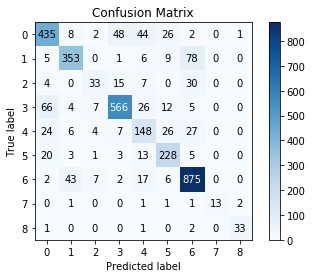

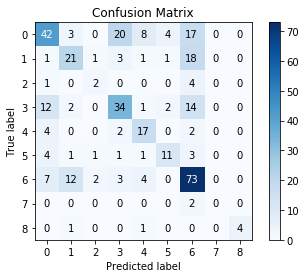

In [66]:
param_grid = {
    'layers': [[512, 256]],
    'activations': [['relu', 'tanh', 'tanh']],
    'dropout': [0.5],
    'lr': [0.01],
    'input_dim': [len(X[0])]
}

model = KerasClassifier(build_fn=make_mlp, batch_size=128, epochs=100, verbose=2, 
                        callbacks=[EarlyStopping(patience=5)])
clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, verbose=1)

result = evaluate(clf, X, y, X_test=X_test, y_test=y_test)

print("Best: %f using %s" % (result.best_score_, result.best_params_))

In [29]:
model = Sequential()
model.add(LSTM(512, input_shape=(1, 1000), dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Xr = X.reshape((-1, 1, 1000))
X_testr = X_test.reshape((-1, 1, 1000))

model.fit(Xr, y, verbose=1, batch_size=64, epochs=50, validation_data=(X_testr, y_test), 
          callbacks=[EarlyStopping(patience=8)])

score = model.evaluate(X_testr, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 3316 samples, validate on 368 samples
Epoch 1/50
3316/3316 [==============================] - 7s - loss: 1.7686 - acc: 0.3598 - val_loss: 1.4712 - val_acc: 0.4891
Epoch 2/50
3316/3316 [==============================] - 6s - loss: 1.3647 - acc: 0.5259 - val_loss: 1.3796 - val_acc: 0.5027
Epoch 3/50
3316/3316 [==============================] - 6s - loss: 1.2009 - acc: 0.5793 - val_loss: 1.3348 - val_acc: 0.5245
Epoch 4/50
3316/3316 [==============================] - 7s - loss: 1.1011 - acc: 0.5986 - val_loss: 1.2963 - val_acc: 0.5408
Epoch 5/50
3316/3316 [==============================] - 10s - loss: 1.0361 - acc: 0.6119 - val_loss: 1.3314 - val_acc: 0.5136
Epoch 6/50
3316/3316 [==============================] - 7s - loss: 0.9747 - acc: 0.6248 - val_loss: 1.3083 - val_acc: 0.5380
Epoch 7/50
3316/3316 [==============================] - 7s - loss: 0.9203 - acc: 0.6438 - val_loss: 1.2915 - val_acc: 0.5679
Epoch 8/50
3316/3316 [==============================] - 6s - loss: 0.8833 - a